<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/ml/mc_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Monte Carlo FrozenLake

Use MC method to solve FrozenLake game.

[OpenAI Gym FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) is defined on a 4x4 matrix. The agent wants to go from top left (S) to bottom right (G). Each grid can be either frozen surface (F) or hold (H). Four possible actions or moves are Left: 0, Down: 1, Right: 2, Up: 3. If the agent reaches goal (G), she receives reward of 1.

MC control is on policy, Monte Carlo, mondel free method. It counts first visits to a state across episodes, and calculate avarage Q values in incremental format as

$$
\begin{aligned}
N(s, a) &\leftarrow N(s, a) + 1  \\
Q(s, a) &\leftarrow Q(s,a) + \frac{1}{N(s, a)}\left( G - Q(s, a) \right)  \\
G &=r_t+\gamma r_{t+1}+ \gamma^2 r_{t+2} + \cdots
\end{aligned}
$$


__Reference__
* Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.
* [RL by David Silver](https://www.davidsilver.uk/teaching/)
* [Lil'Log](https://lilianweng.github.io/lil-log/)
* [Deep Learning with TensorFlow](https://github.com/dragen1860/Deep-Learning-with-TensorFlow-book)
* [Reinforcement Learning](https://github.com/dennybritz/reinforcement-learning)
* [marcinbogdanski](https://marcinbogdanski.github.io/reinforcement-learning.html)

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym

In [60]:
env = gym.make('FrozenLake-v0', is_slippery=True)   # may not head for the direction chosen

In [68]:
n_episodes = 50000
epsilon = 0.1               # epsilon greedy
epsilon_final = 0.05
epsilon_decay = (epsilon-epsilon_final)/n_episodes   # epsilon annealing
gamma = 0.99                # discount factor

# Q-Table, default to 0
Q = np.zeros((env.observation_space.n, env.action_space.n))
N = np.zeros([env.observation_space.n, env.action_space.n])
# action space
actions = range(env.action_space.n)

In [69]:
reward_history = []
step_history = []

for n_episode in range(n_episodes):
    s = env.reset()          # reset to initial state
    # env.render()
    done = False
    reward = 0.
    step = 0
    s_a_r_episode = []

    # finish episode first
    while not done:
        # choose action according to epsilon greedy
        a = 0
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:   # randomly pick one in case of a tie
            candidates = np.argwhere(Q[s, :] == np.amax(Q[s, :]))
            candidates = candidates.reshape(-1,)
            a = np.random.choice(candidates)

        # use a to interact with environment
        s_prime, r, done, info = env.step(a)
        s = s_prime
        s_a_r_episode.append([s, a, r])
        step += 1
        reward += r
    
    # Update all (state, action) pairs we've visited in this episode
    sa_in_episode = set([(x[0], x[1]) for x in s_a_r_episode])
    for state, action in sa_in_episode:
        first_occurrence_idx = next(i for i,x in enumerate(s_a_r_episode) if x[0] == state and x[1] == action)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(s_a_r_episode[first_occurrence_idx:])])
        N[state, action] += 1.0
        alpha = 1.0 / N[state, action]
        # update q values
        Q[state, action] = Q[state, action] + alpha * (G - Q[state, action])

    reward_history.append(reward)
    step_history.append(step)

    epsilon -= epsilon_decay

    if (n_episode + 1) % 5000 == 0:
        print(f'Episode {n_episode + 1}/{n_episodes}.')

Episode 5000/50000.
Episode 10000/50000.
Episode 15000/50000.
Episode 20000/50000.
Episode 25000/50000.
Episode 30000/50000.
Episode 35000/50000.
Episode 40000/50000.
Episode 45000/50000.
Episode 50000/50000.


In [70]:
env.close()

Text(0.5, 1.0, 'Average steps')

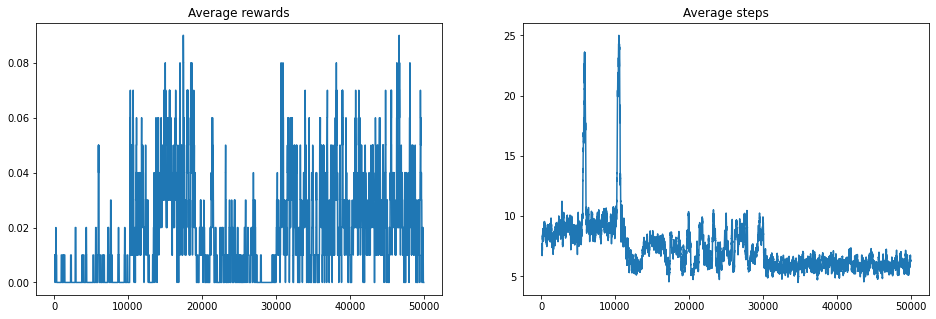

In [71]:
df_stats = pd.DataFrame.from_dict({'rewards': reward_history, 'steps': step_history})
fig, ax = plt.subplots(1, 2, figsize=(16,5))
df_stats['rewards'].rolling(100).mean().plot(ax=ax[0])
ax[0].set_title('Average rewards')
df_stats['steps'].rolling(100).mean().plot(ax=ax[1])
ax[1].set_title('Average steps')